# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
# from scipy.misc import imread, imresize
import datetime
import os
# import scipy

http://francescopochetti.com/video-classification-in-keras-a-couple-of-approaches/

In [2]:
from skimage.io import imread
from skimage.transform import resize

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

Using TensorFlow backend.


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.optimizers import Adam

In [6]:
from keras.layers import Dense, Flatten, Dropout, ZeroPadding3D, Input
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model, Model
from keras.optimizers import Adam, RMSprop, Nadam
from keras.layers.wrappers import TimeDistributed
from keras.layers.convolutional import (Conv2D, MaxPooling3D, Conv3D, MaxPooling2D)
from collections import deque
from keras import regularizers, initializers
from keras.initializers import glorot_uniform

from keras.applications.vgg16 import VGG16
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers.recurrent import LSTM

In [8]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls "/content/drive/My Drive/Colab Notebooks/"

 1.+Cifar_10_with_dropout_without_BN.ipynb
'Copy of Telecom_churn_caseStudy_Submision.ipynb'
 internet_data.csv
'MNIST - PCA.ipynb'
 Neural_Nets_Project_Starter_Code_1.ipynb
 Neural_Nets_Project_Starter_Code_4.ipynb
 Neural_Nets_Project_Starter_Code_5.ipynb
 Neural_Nets_Project_Starter_Code_5_old.ipynb
 Project_data.zip
'Python recap.ipynb'
 Telecom_churn_caseStudy_Submision.ipynb
 telecom_churn_data.csv
 TelecomChurn-Upgrad.ipynb
 v2_eda_svm.ipynb


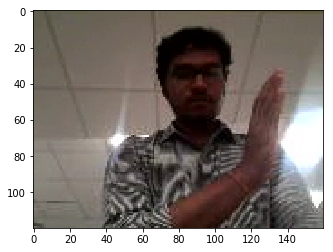

In [7]:
test = imread('./Project_data/train/WIN_20180926_18_09_50_Pro_Right_Swipe_new/WIN_20180926_18_09_50_Pro_00013.png')

plt.imshow(test)

In [8]:
test.shape

(120, 160, 3)

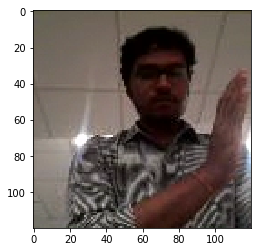

In [9]:
test_updated = test[0:120,20:140]
plt.imshow(test_updated)

In [10]:
test_updated_1 = resize(test_updated, (100,100))

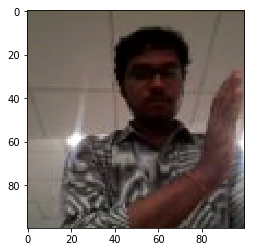

In [11]:
plt.imshow(test_updated_1)

In [12]:
test_updated_1[:,:,0]

array([[0.39141176, 0.38588235, 0.38862745, ..., 0.36078431, 0.3605098 ,
        0.36321569],
       [0.392     , 0.39105882, 0.3927451 , ..., 0.40607843, 0.4047451 ,
        0.40039216],
       [0.39490196, 0.40078431, 0.39901961, ..., 0.43039216, 0.43137255,
        0.42960784],
       ...,
       [0.45490196, 0.45372549, 0.45098039, ..., 0.21470588, 0.24941176,
        0.29117647],
       [0.45490196, 0.45372549, 0.45098039, ..., 0.22901961, 0.22666667,
        0.19443137],
       [0.4372549 , 0.43607843, 0.43333333, ..., 0.22431373, 0.16407843,
        0.22431373]])

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

#### Constant Variables

In [13]:
image_width = 100
image_height = 100

image_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]

In [14]:
train_path = './Project_data/train'
val_path = './Project_data/val'

train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())

In [15]:
# train_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/train.csv').readlines())
# val_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/val.csv').readlines())

# train_path = '/notebooks/storage/Final_data/Collated_training/train'
# val_path = '/notebooks/storage/Final_data/Collated_training/val'

In [16]:
def norm1(image):
    epsilon = 1e-7
    norm_image = (image - image.mean(axis=(0,1,2), keepdims=True)) / image.std(axis=(0,1,2), keepdims=True)
    return norm_image

In [17]:
def norm2(image):
    return np.array((image - np.min(image)) / (np.max(image) - np.min(image)))

In [18]:
def norm3(image):
    return (image - np.percentile(image,5)) / (np.percentile(image,95) - np.percentile(image,5))

### Check Images for cropping

In [19]:
a = np.random.permutation(train_doc)
print(len(a))

663


In [20]:
a = a[::100]

In [21]:
len(a)

7

In [22]:
a[0].split(';')

['WIN_20180926_17_24_58_Pro_Right_Swipe_new', 'Right_Swipe_new', '1\n']

In [23]:
fig = plt.figure(figsize=(30, 30))  # width, height in inches

def plot_image(images, cmap=None):
    y = len(images)//3+1
    
    for i in range(len(image)):
        sub = fig.add_subplot(4, y, i + 1)
        sub.imshow(images[i], interpolation='nearest')
    
#     f, axes = plt.subplots(3, len(images))
#     f.set_figwidth(15)
#     for ax,image in zip(axes, images):
#         plt.imshow(image, cmap)

<Figure size 2160x2160 with 0 Axes>

In [24]:

img_arr = []
for folder in range(len(a)):
    imgs = os.listdir(train_path+'/'+ a[folder].split(';')[0]) # read all the images in the folder
    for idx,item in enumerate(image_idx): #  Iterate iver the frames/images of a folder to read them in
        image = imread(train_path+'/'+ a[folder].strip().split(';')[0]+'/'+imgs[item])
        img_arr.append(image)

# print(len(img_arr))
# print(img_arr[0])
# plot_image(img_arr)

    

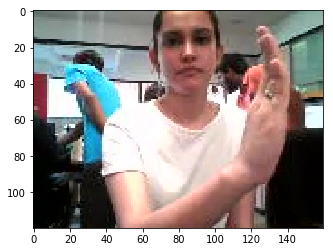

In [25]:
plt.imshow(img_arr[0])

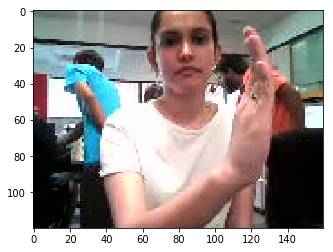

In [26]:
plt.imshow(img_arr[5])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [27]:
def retrieve_images_as_per_batch(source_path, folder_list, batch, batch_size, t, img_idx, image_norm_method=2):
    x = len(img_idx)
    y = image_height
    z = image_width      

    batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output

    for folder in range(batch_size): # iterate over the batch_size
        
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        
        for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
            image = imread(source_path+'/'+ 
                           t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])

            if(image.shape[0]!=image.shape[1]):
                image=image[0:120,20:140]

            # image = imresize(image, (y,z))
            image = resize(image, (y,z))

            if image_norm_method==1:
                norm_image = norm1(image)
            elif image_norm_method ==2:
                norm_image = norm2(image)
            else:
                norm_image = norm3(image)

            batch_data[folder,idx,:,:,0] = norm_image[:,:,0]
            batch_data[folder,idx,:,:,1] = norm_image[:,:,1]
            batch_data[folder,idx,:,:,2] = norm_image[:,:,2]

        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
    return batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [28]:
def generator(source_path, folder_list, batch_size, image_idx, image_norm_method=2):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = image_idx
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list) // batch_size
        
        # for remaining videos
        remaining_sequences = len(folder_list) % batch_size
        
        for batch in range(num_batches): # we iterate over the number of batches
            yield retrieve_images_as_per_batch(source_path, folder_list, batch, batch_size, t, image_idx)

        
        # write the code for the remaining data points which are left after full batches
        if remaining_sequences != 0:
            yield retrieve_images_as_per_batch(source_path, folder_list, num_batches, remaining_sequences, t, image_idx)

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [29]:
curr_dt_time = datetime.datetime.now()

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)


# training sequences = 663
# validation sequences = 100


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [30]:
def create_train_val_generators(batch_size, image_idx, img_dim):
    train_generator = generator(train_path, train_doc, batch_size, image_idx,image_norm_method=2)
    val_generator = generator(val_path, val_doc, batch_size, image_idx, image_norm_method=2)
    
    return train_generator, val_generator

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## 3d CNN models

- https://ieeexplore.ieee.org/document/8545718 (later experiment with more conv)

In [31]:
def create_3d_cnn_model(input_shape, filters=[32,64,128,256], optimiser=Adam()):

    filter_size = filters
    dense_layer_size = [512,256]
    
    initializer = glorot_uniform(seed = np.random.seed(30))
    model = Sequential()

    #Layer 1
    model.add(Conv3D(filters=filter_size[0],kernel_size=(7,7,3), input_shape=input_shape, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv3D(filters=filter_size[0],kernel_size=(3,3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2,2,2)))


    #Layer 2
    model.add(Conv3D(filters=filter_size[1],kernel_size=(3,3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv3D(filters=filter_size[1],kernel_size=(3,3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2,2,2)))


    #Layer 3
    model.add(Conv3D(filters=filter_size[2],kernel_size=(1,3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv3D(filters=filter_size[2],kernel_size=(1,3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2,2,2)))

    # model.add(Dropout(0.25))

    # #Layer 4
    model.add(Conv3D(filters=filter_size[3],kernel_size=(1,3,3), padding='same')) # 'valid'
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv3D(filters=filter_size[3],kernel_size=(1,3,3), padding='same')) # 'valid'
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2,2,2)))

    model.add(Dropout(0.25))


    #Flatten Layers
    model.add(Flatten())

    # Dense 1
    model.add(Dense(dense_layer_size[0], activation='relu'))
    model.add(Dropout(0.5))

    # Dense 2
    model.add(Dense(dense_layer_size[1], activation='relu'))
    model.add(Dropout(0.5))

    # final softmax
    #softmax layer
    model.add(Dense(5, activation='softmax'))
    
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print (model.summary())
    
    return model

### Convolutions + RNN
- The conv2D network will extract a feature vector for each image, and a sequence of these feature vectors is then fed to an RNN-based network. The output of the RNN is a regular softmax (for a classification problem such as this one).

#### There are a few key things to note about the conv-RNN architecture:

- You can use transfer learning in the 2D CNN layer rather than training your own CNN 
- GRU can be a better choice than an LSTM since it has lesser number of gates (and thus parameters)

In [32]:
def create_lrcn_model(input_shape):
        """Build a CNN into RNN.
        Starting version from:
            https://github.com/udacity/self-driving-car/blob/master/
                steering-models/community-models/chauffeur/models.py

        Heavily influenced by VGG-16:
            https://arxiv.org/abs/1409.1556

        Also known as an LRCN:
            https://arxiv.org/pdf/1411.4389.pdf
        """
        def add_default_block(model, kernel_filters, init, reg_lambda):

            # conv
            model.add(TimeDistributed(Conv2D(kernel_filters, (3, 3), padding='same',
                                             kernel_initializer=init, kernel_regularizer=regularizers.l2(l=reg_lambda))))
            
            model.add(TimeDistributed(BatchNormalization()))
            model.add(TimeDistributed(Activation('relu')))
            # conv
            model.add(TimeDistributed(Conv2D(kernel_filters, (3, 3), padding='same',
                                             kernel_initializer=init, kernel_regularizer=regularizers.l2(l=reg_lambda))))
            model.add(TimeDistributed(BatchNormalization()))
            model.add(TimeDistributed(Activation('relu')))
            # max pool
            model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

            return model

        # Xavier normal initializer
        initialiser = glorot_uniform()
        # model is overfitting - add regularization
        reg_lambda  = 0.001

        model = Sequential()

        # first (non-default) block
        model.add(TimeDistributed(Conv2D(32, (7, 7), strides=(2, 2), padding='same',
                                         kernel_initializer=initialiser, kernel_regularizer=regularizers.l2(l=reg_lambda)),
                                  input_shape=input_shape))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(Activation('relu')))
        model.add(TimeDistributed(Conv2D(32, (3,3), kernel_initializer=initialiser, kernel_regularizer=regularizers.l2(l=reg_lambda))))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(Activation('relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

        # 2nd-5th (default) blocks
        model = add_default_block(model, 64,  init=initialiser, reg_lambda=reg_lambda)
        model = add_default_block(model, 128, init=initialiser, reg_lambda=reg_lambda)
        model = add_default_block(model, 256, init=initialiser, reg_lambda=reg_lambda)
        model = add_default_block(model, 512, init=initialiser, reg_lambda=reg_lambda)

        # LSTM output head
        model.add(TimeDistributed(Flatten()))
        model.add(LSTM(256, return_sequences=False, dropout=0.5))
        model.add(Dense(5, activation='softmax'))
        
        model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print (model.summary())

        return model

### VGG + LSTM

In [35]:
# cnn_base = VGG16(input_shape=(image_height,image_width,3), weights="imagenet", include_top=False)

In [36]:
def create_vgg_lstm_model():
    video = Input(shape=(len(image_idx),
                         image_height, # rows
                         image_width,3)) # columns

    cnn_base = VGG16(input_shape=(image_height,image_width,3), weights="imagenet", include_top=False)

    cnn_out = GlobalAveragePooling2D()(cnn_base.output)
    cnn = Model(input=cnn_base.input, output=cnn_out)
    cnn.trainable = False

    encoded_frames = TimeDistributed(cnn)(video)
    encoded_sequence = LSTM(256)(encoded_frames)

    hidden_layer = Dense(output_dim=1024, activation="relu")(encoded_sequence)

    outputs = Dense(output_dim=5, activation="softmax")(hidden_layer)

    model = Model([video], outputs)

    optimizer = Nadam(lr=0.002,
                      beta_1=0.9,
                      beta_2=0.999,
                      epsilon=1e-08,
                      schedule_decay=0.004)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    print(model.summary())
    
    return model

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [37]:
def train_model_int(model, train_generator, val_generator, batch_size, num_epochs, model_log):
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
        
    model_name = model_log + 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') +'/'
    
    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model_-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
    #early stopping required
    ES = EarlyStopping(monitor='val_loss', verbose=1, patience=10)
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, 
                                 save_weights_only=False, mode='auto', period=1)
    
    # patience can be increased with early stopping (5)
    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, cooldown=1, verbose=1)
    
    # callbacks_list = [checkpoint, LR, ES]
    callbacks_list = [checkpoint, LR]
    
    model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [38]:
def train_cnn3d_model(epoch, batch_size, log,filters = [16,16,32,64], optimizer=Adam()):
    
    batch_size = batch_size
    num_epochs = epoch
    img_dim = (image_height,image_width)
    
    train_gen, val_gen = create_train_val_generators(batch_size=batch_size,image_idx=image_idx,img_dim=img_dim)
    
    # length of video sequence, width, height, num_channels
    input_shape=(len(image_idx), image_width, image_height, 3)
    
    model = create_3d_cnn_model(input_shape=input_shape, filters=filters, optimiser=optimizer)
    
    train_model_int(model = model, train_generator=train_gen, val_generator=val_gen, batch_size=batch_size,num_epochs=epoch,model_log=log)

In [0]:
# train_cnn3d_model(epoch=1, batch_size=8, log = 'temp')

In [39]:
def train_vgg_rnn_lstm_model(epoch, batch_size, log):
    
    batch_size = batch_size
    num_epochs = epoch
    
    img_dim = (image_height,image_width)
    
    train_gen, val_gen = create_train_val_generators(batch_size=batch_size,image_idx=image_idx,img_dim=img_dim)
    
    # length of video sequence, width, height, num_channels
    input_shape=(len(image_idx), image_width, image_height, 3)
    
    model = create_vgg_lstm_model()
    
    train_model_int(model = model, train_generator=train_gen, val_generator=val_gen, batch_size=batch_size,num_epochs=epoch,model_log=log)

In [40]:
train_vgg_rnn_lstm_model(1,8,'vgg')

c:\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("gl...)`
  if __name__ == '__main__':
c:\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1024, activation="relu")`
  from ipykernel import kernelapp as app
c:\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=5, activation="softmax")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 18, 100, 100, 3)   0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 18, 512)           14714688  
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              263168    
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 5125      
Total params: 15,770,437
Trainable params: 15,770,437
Non-trainable params: 0
_________________________________________________________________
None
Source path = Source path =  ./Project_data/train ; batch size = 8
Epoch 1/1
 ./Project_data/val ; batch size = 8


ResourceExhaustedError: OOM when allocating tensor with shape[144,64,100,100] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: time_distributed_2/block1_conv2/convolution = Conv2D[T=DT_FLOAT, _class=["loc:@train...propFilter"], data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](time_distributed_2/block1_conv1/Relu, block1_conv2_2/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: loss_1/mul/_709 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_3672_loss_1/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [41]:
train_cnn3d_model(epoch=20, batch_size=8, log ='3dcnn')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 18, 100, 100, 16)  7072      
_________________________________________________________________
batch_normalization_1 (Batch (None, 18, 100, 100, 16)  64        
_________________________________________________________________
activation_1 (Activation)    (None, 18, 100, 100, 16)  0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 18, 100, 100, 16)  6928      
_________________________________________________________________
batch_normalization_2 (Batch (None, 18, 100, 100, 16)  64        
_________________________________________________________________
activation_2 (Activation)    (None, 18, 100, 100, 16)  0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 9, 50, 50, 16)     0         
__________

83/83 [==============================] - 191s 2s/step - loss: 0.8883 - categorical_accuracy: 0.6457 - val_loss: 1.5833 - val_categorical_accuracy: 0.4300

Epoch 00012: val_loss did not improve from 0.82751
Epoch 13/20
83/83 [==============================] - 190s 2s/step - loss: 0.9144 - categorical_accuracy: 0.6155 - val_loss: 1.6458 - val_categorical_accuracy: 0.4000

Epoch 00013: val_loss did not improve from 0.82751
Epoch 14/20
83/83 [==============================] - 195s 2s/step - loss: 0.9139 - categorical_accuracy: 0.6487 - val_loss: 0.8193 - val_categorical_accuracy: 0.6400

Epoch 00014: val_loss improved from 0.82751 to 0.81931, saving model to 3dcnnmodel_init_2019-09-1823_01_15.311769/model_-00014-0.91449-0.64857-0.81931-0.64000.h5
Epoch 15/20
83/83 [==============================] - 205s 2s/step - loss: 0.7736 - categorical_accuracy: 0.6745 - val_loss: 0.8103 - val_categorical_accuracy: 0.6700

Epoch 00015: val_loss improved from 0.81931 to 0.81033, saving model to 3dcnnmod

In [42]:
def train_lrcn(epoch, batch_size, img_norm_method, log, optimizer=Adam(), filters = [16,32,64,64]):
    
    image_width = 100
    image_height = 100
    
    image_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]

    batch_size = batch_size
    num_epochs = epoch
    img_dim = (image_height,image_width)
    train_gen, val_gen = create_train_val_generators(batch_size=batch_size,image_idx=image_idx,img_dim=img_dim)
    
    # length of video sequence, width, height, num_channels
    input_shape=(len(image_idx), image_width, image_height, 3)
    
    model = create_lrcn_model(input_shape=input_shape)
    
    train_model_int(model = model, train_generator=train_gen, val_generator=val_gen, batch_size=batch_size,num_epochs=epoch,model_log=log)

In [43]:
print("1"*100)
train_lrcn(epoch=20, batch_size=8, img_norm_method=2, log="lrcn_norm-1",filters = [16,16,32,64])
print("1"*100)

1111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_3 (TimeDist (None, 18, 50, 50, 32)    4736      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 18, 50, 50, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 18, 50, 50, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 18, 48, 48, 32)    9248      
_________________________________________________________________
time_distributed_7 (TimeDist (None, 18, 48, 48, 32)    128       
_________________________________________________________________
time_distributed_8 (TimeDist (None, 18, 48, 48, 32)    0         
_________________________________________

Epoch 10/20
83/83 [==============================] - 195s 2s/step - loss: 1.3356 - categorical_accuracy: 0.7468 - val_loss: 1.5645 - val_categorical_accuracy: 0.6200

Epoch 00010: val_loss improved from 2.05092 to 1.56453, saving model to lrcn_norm-1model_init_2019-09-1823_01_15.311769/model_-00010-1.33605-0.74661-1.56453-0.62000.h5
Epoch 11/20
83/83 [==============================] - 160s 2s/step - loss: 1.2804 - categorical_accuracy: 0.7681 - val_loss: 1.5422 - val_categorical_accuracy: 0.6600

Epoch 00011: val_loss improved from 1.56453 to 1.54219, saving model to lrcn_norm-1model_init_2019-09-1823_01_15.311769/model_-00011-1.28104-0.76772-1.54219-0.66000.h5
Epoch 12/20
83/83 [==============================] - 169s 2s/step - loss: 1.2270 - categorical_accuracy: 0.7829 - val_loss: 1.5998 - val_categorical_accuracy: 0.5900

Epoch 00012: val_loss did not improve from 1.54219
Epoch 13/20
83/83 [==============================] - 175s 2s/step - loss: 1.2662 - categorical_accuracy: 0.7726 